In [19]:
import json 
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np 
import pandas as pd

from calibration_metric import ECEMetric
from calibration_utils import get_accs_sql, read_benchclamp_file, get_probs_and_accs_benchclamp

In [4]:

bart_data = read_benchclamp_file("/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_spider_past_none_db_val_all_0.0001_5000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T031316.jsonl")
# bart_min_probs, bart_mean_probs, bart_accs = get_probs_and_accs_benchclamp(bart_data) 
spider_gold_path = "/brtx/601-nvme1/estengel/resources/data/benchclamp/processed/Spider/test_all.jsonl"
bart_min_probs, bart_mean_probs, bart_exact_accs = get_probs_and_accs_benchclamp(bart_data) # , spider_gold_path) 

In [5]:
ece_metric = ECEMetric(n_bins=10, binning_strategy="adaptive")
(min_values_em, 
min_bins, 
min_bin_number) = ece_metric.adaptive_bin(bart_min_probs, bart_exact_accs)

# convert exact match accuracy to evaluation accuracy
# print(f"getting sql execution accuracy for each bin")
# min_execution_accs = get_accs_sql(bart_data, spider_gold_path, min_bin_number) 
# print(f"replacing exact match accuracy with execution accuracy...")
# replace the accuracies with copies of the average for computing the ECE on the eval match accuracy

min_df_to_plot_em = ece_metric.bins_to_df(min_values_em, min_bins, min_bin_number)
# min_df_to_plot_ev = ece_metric.bins_to_df(min_values_ev, min_bins, min_bin_number)

replacing exact match accuracy with execution accuracy...


In [13]:
min_df_to_plot_em.columns

source_ppl_data = json.load(open("spider_test_by_bart_bin/conf_and_ppl_source.json"))
target_ppl_data = json.load(open("spider_test_by_bart_bin/conf_and_ppl_target.json"))

# sort by confidence, decreasing
target_ppl_data = sorted(target_ppl_data, key=lambda x: x[0], reverse=True)
source_ppl_data = sorted(source_ppl_data, key=lambda x: x[0], reverse=True)
# add source data to df 
min_df_to_plot_em['target_ppl'] = [x[1] for x in target_ppl_data]
min_df_to_plot_em['source_ppl'] = [x[1] for x in source_ppl_data]



In [21]:
# ece is absolute difference between model and correct

min_df_to_plot_em['bin_ece'] = min_df_to_plot_em['prob_model'] - min_df_to_plot_em['prob_correct']
min_df_to_plot_em['bin_ece'] = min_df_to_plot_em['bin_ece'].abs()

<AxesSubplot:xlabel='source_ppl', ylabel='bin_ece'>

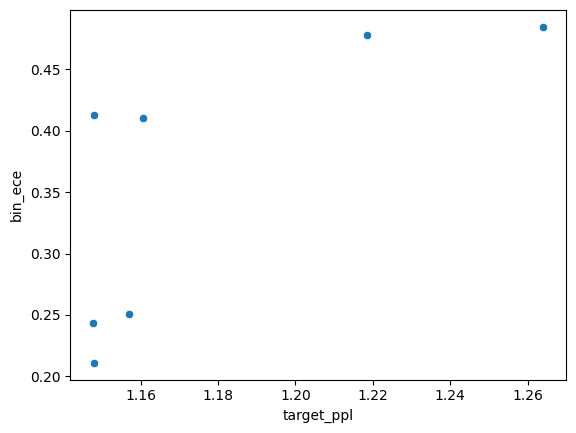

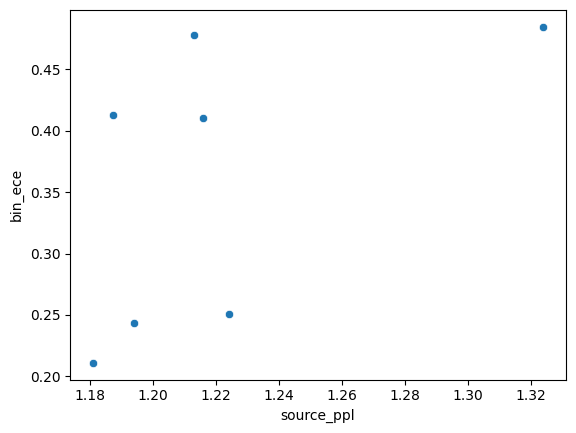

In [25]:

sns.scatterplot(data= min_df_to_plot_em, x='target_ppl', y='bin_ece')
plt.figure()
sns.scatterplot(data= min_df_to_plot_em, x='source_ppl', y='bin_ece')